<a href="https://colab.research.google.com/github/Eserhimas/Basics/blob/main/Text_Classification_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text

In [ ]:
!pip install tf-models-official

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import logging
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from google.colab import drive
from official.nlp import optimization

In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Configures
batch_size = 32
logger = logging.getLogger()
logger.setLevel('ERROR')
AUTOTUNE = tf.data.AUTOTUNE

raw_ds = tf.keras.utils.text_dataset_from_directory('/content/gdrive/MyDrive/Datasets/movie_reviews')
class_names = raw_ds.class_names

print(class_names)

Found 2000 files belonging to 2 classes.
['neg', 'pos']


In [8]:
def partition_dataset_tf(dataset, ds_size, train_split=0.8, val_split=0.1,
                         test_split=0.1, shuffle=True, shuffle_size=1000):

  assert(train_split + test_split + val_split) ==1

  if shuffle:
    dataset = dataset.shuffle(shuffle_size, seed=420)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = dataset.take(train_size)
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = partition_dataset_tf(raw_ds, len(raw_ds))

In [10]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {'small_bert/bert_en_uncased_L-4_H-512_A-8':
											'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}

map_model_to_preprocess = {'small_bert/bert_en_uncased_L-4_H-512_A-8':
											'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

In [11]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
def build_classifier_model():

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

  return tf.keras.Model(text_input, net)

In [14]:
classifier_model = build_classifier_model()

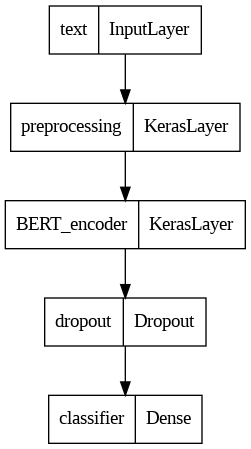

In [15]:
tf.keras.utils.plot_model(classifier_model)

In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
metrics = tf.metrics.BinaryAccuracy()

In [18]:
epochs = 15

In [19]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
print(steps_per_epoch)

50


In [20]:
num_train_steps = steps_per_epoch * epochs
num_train_steps

750

In [21]:
num_warmup_steps = int(0.1 * num_train_steps)

In [22]:
init_lr = 3e-5

In [23]:
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')

In [24]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [25]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [26]:
history = classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    verbose=2,
    epochs=epochs)

Epoch 1/15
50/50 - 168s - loss: 0.7196 - binary_accuracy: 0.5196 - val_loss: 0.6531 - val_binary_accuracy: 0.5521 - 168s/epoch - 3s/step
Epoch 2/15
50/50 - 17s - loss: 0.6592 - binary_accuracy: 0.5808 - val_loss: 0.5535 - val_binary_accuracy: 0.6458 - 17s/epoch - 346ms/step
Epoch 3/15
50/50 - 16s - loss: 0.5885 - binary_accuracy: 0.6559 - val_loss: 0.4834 - val_binary_accuracy: 0.7396 - 16s/epoch - 324ms/step
Epoch 4/15
50/50 - 17s - loss: 0.5141 - binary_accuracy: 0.7386 - val_loss: 0.3847 - val_binary_accuracy: 0.8229 - 17s/epoch - 333ms/step
Epoch 5/15
50/50 - 16s - loss: 0.4388 - binary_accuracy: 0.7866 - val_loss: 0.3628 - val_binary_accuracy: 0.7708 - 16s/epoch - 327ms/step
Epoch 6/15
50/50 - 17s - loss: 0.3601 - binary_accuracy: 0.8295 - val_loss: 0.2076 - val_binary_accuracy: 0.9115 - 17s/epoch - 348ms/step
Epoch 7/15
50/50 - 16s - loss: 0.2858 - binary_accuracy: 0.8775 - val_loss: 0.1360 - val_binary_accuracy: 0.9688 - 16s/epoch - 327ms/step
Epoch 8/15
50/50 - 16s - loss: 0.23

In [27]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [29]:
epochs = range(1, len(acc) + 1)

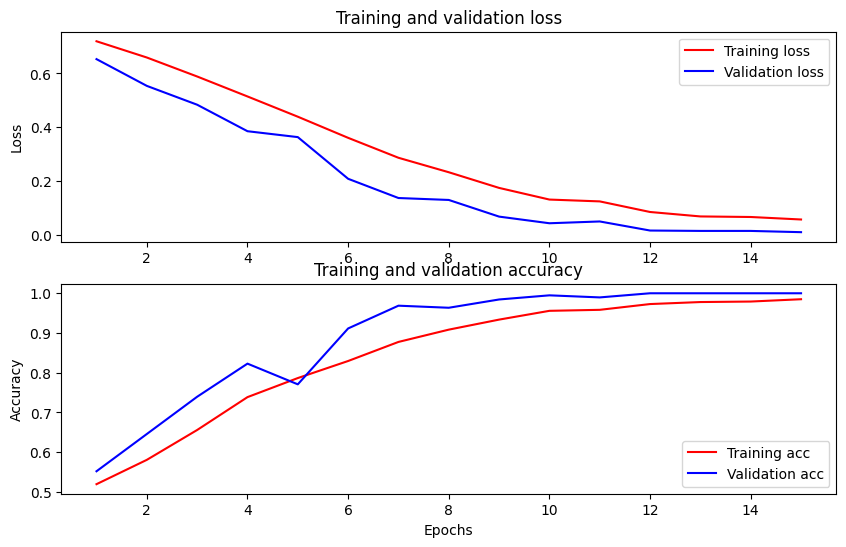

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [35]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
print(history.history.keys())

In [36]:
loss, accuracy = classifier_model.evaluate(test_ds)

7/7 [==============================] - 3s 142ms/step - loss: 0.0288 - binary_accuracy: 0.9911


In [38]:
classifier_model.save('/content/gdrive/MyDrive/Models', include_optimizer=False)